# Autómatas celulares

Los autómatas celulares son una herramienta para modelar sistemas dinámicos y complejos de manera discreta. Entán compuestos por un conjunto finito de celdas capaces de adquirir distintos estados o valores de acuerdo con unas reglas de comportamiento.

De manera formal definiremos a un autómata celular como la tupla $A = (\mathcal{L}, \tau, \Sigma, \phi)$, donde:

* $\mathcal{L}$ es un espacio discreto d-dimensional dividido de manera uniforme.
* $\Sigma$ es el conjunto de todos los posibles estados del autómata celular.
* $\tau$ es un sistema de vecindades definido a partir de las vecindades de cada celda o célula.
* $\phi:\overbrace{\Sigma\times\Sigma\times\cdots\times\Sigma}^{N}\to\Sigma$ es la regla de transición (o evolución) que define la manera en la que se actualiza el estado de cada celda teniendo en cuenta sus $N$ vecinos.

$\textbf{Observación:}$ Trabajaremos sobre espacios discretos de dos dimensiones salvo se indique lo contrario.

Antes de continuar con la definición de las reglas para nuestros modelos epidemiológicos, debemos profundizar algunos de conceptos anteriores:

Tipicamente cuando se desarrollan análisis con autómatas celulares se trabaja con sistemas de vecindades definidos a partir de la vecindad de Moore o de la vecindad de Von neumann. Esta vecindad se compone de todas las células que rodean a la ubicada en alguna posición $i,j$ en nuestro espacio, la definimos como 

$$\mathcal{V}_M(x_{i,j}) = \{x_{k,l}||i-k|,|j-l|\leq1\text{, con }k,l\in\mathbb{Z}\}$$

Por otro lado encontramos a la vecindad de Von neumman, esta vecindad se compone de las celdas que rodean a la ubicada en la posición $i,j$ sin contar a los que se encuentran en las "esquinas". Se define como:

$$\mathcal{V}_V(x_{i,j}) = \{x_{k,l}||i-k|+|j-l|\leq1\text{, con }k,l\in\mathbb{Z}\}$$

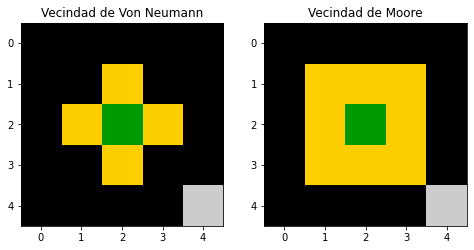

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from EpidemiologicalModels.DefineSpaceInCA import *

Vecindad_Moore = np.zeros((3,3)); Vecindad_Moore[1,1] = 2
Vecindad_Von_Neumann = np.ones((3,3))
Vecindad_Von_Neumann[0:,1] = 0; Vecindad_Von_Neumann[1,0:] = 0; Vecindad_Von_Neumann[1,1] = 2

figsize(8,4)

plt.subplot(1,2,1)
plt.title("Vecindad de Von Neumann")
plt.imshow(color(Von_Neumann(Vecindad_Von_Neumann,1,1)[0]),cmap="nipy_spectral", interpolation='nearest')

plt.subplot(1,2,2)
plt.title("Vecindad de Moore")
plt.imshow(color(Moore(Vecindad_Moore,1,1)[0]), cmap="nipy_spectral",interpolation='nearest')

plt.show()

En cuanto a la condición de frontera sobre mnuestro espacio para trabajar con este tipo de vecindades usaremos los bordes de tipo absorvente[5], en los que se consideran unicamente los vecinos dentro de los limites del sistema. Para poder trabajar con este tipo de bordes es necesario aumentar el tamaño de nuestro espacio tanto como la dimensión de la vecindad nos lo indique. 

![texto del enlace](Imagenes/condicionFrontera.PNG)

En el diagrama anterior podemos apreciar la manera en la que se toman los vecinos de los individuos cercanos a los bordes, adicionalmente se aprecian los estados que conseraremos para nuestros análisis, es decir, $\Sigma=\{\text{susceptibles, infectados, recuperados, muertos, espacios vacios}\} = \{S,I,R,M,V\}$.

Existen dos tipos de reglas de evolución para autómatas celulares, las determinísticas y las totalísticas. Las $\textbf{reglas deterministicas}$ son aquellas en las que se determina un estado para cada posible configuración del vecindario, esto complica demasiado las cosas en un sistema de dos dimensiones ya que podemos tener $5^{5^9}$ configuraciones para la vecindad de Moore y $5^{5^5}$ configuraciones para la vecindad de Von neumann[5].

En el caso de las $\textbf{reglas totalísticas}$ se definen los estados a partir de propiedades sobre las vecindades, por ejemplo se podria tener una regla que se aplique solo si hay 3 de 9 vecinos susceptibles o 1 de 6 recuperados. Este tipo de regla facilita en gran medida la construcción de análisis sobre autómatas celulares ya que se requiere de un menor almacenamiento en memoria para la cantidad de posibles casos.

En nuestro caso usaremos el tipo de regla totalística en el que la célula central se considera unicamente para determinar la condición en la que se aplica la regla de evolución y no para definir la propiedad en la que se aplica directamente la regla.

# Reglas de evolución para modelos epidemiológicos

Para definir las reglas de evolución para nuestros autómatas celulares partiremos desde los modelos mas simplificados, analizando los posibles escenarios que se pueden describir por medio de los modelos clásicos para posteriormente validar los comportamientos simulados a partir de nuestros autómatas celulares.

Antes de continuar, consideraremos las siguientes notaciones:
*  La célula en la posición $i,j$ se representará como $x_{i,j}$.
*  Denotaremos a $\pi^t(x_{i,j})$ como el estado de la celda $i,j$ en el momento $t$.
*  La cantidad de individuos que posean el estado $X$ en el tiempo $t$ en la vecindad de $i,j$ se denotara como $\sigma(\mathcal{V}(x_{i,j}),X,t)$.
*  La cantidad de vecinos de la célula $i,j$ se representará como $\#\mathcal{V}(x_i,j)$.

El primer caso que veremos será el del modelo SIS sin natalidad ni mortalidad, es decir, $\mu=\theta=0$.

## El modelo SIS sin natalidad ni mortalidad

Dados $\beta$ y $\alpha$ las tasas de infección y de recuperación respectivamente, el modelo SIS nos afirma que para $R_0=\frac{\beta}{\alpha}>1$ la enfermedad será endemica. Repliquemos esté escenario de manera local sobre una celda:

* Supongamos por un momento que la célula es susceptible con $R_0>1$, esto significa que la probabilidad de adquirir la enfermedad luego de tener contacto con algún infectado es más alta que la probabilidad de que se mantenga sana luego de dicho contacto, pues $\beta>\alpha$. Adicionalmente, si la célula tiene más de un vecino infectado, la probabilidad de infectarse crecerá. De ese modo, para un valor aleatorio $\rho\in[0,1]$ generado uniformemente se tendrá que:

$$"\text{Sea }\pi^t(x_{i,j})=S\text{ y suponga que }\rho>\frac{\beta}{\alpha}\frac{\sigma(\mathcal{V}(x_{i,j}),I,t)}{\#\mathcal{V}(x_{i,j})}\text{, entonces }\pi^{t+1}(x_{i,j})=I\text{, en caso contrario }\pi^{t+1}(x_{i,j})=S"$$

* En el caso en el que la célula está infectada, $R_0>1$ se entiende como que la probabilidad de mantenerse infectado es mayor a la probabilidad de recuperarse. Al igual que en el caso anterior, si hay más de un individuo infectado en la vecindad de un infectado es más probable que la célula se mantenga infectada, de ese modo:

$$"\text{Sea }\pi^t(x_{i,j})=I\text{ y suponga que }\rho\leq\frac{\beta}{\alpha}\frac{\sigma(\mathcal{V}(x_{i,j}),I,t)}{\#\mathcal{V}(x_{i,j})}\text{, entonces }\pi^{t+1}(x_{i,j})=S\text{, en caso contrario }\pi^{t+1}(x_{i,j})=I"$$

Analicemos ahora el caso en el que $R_0<1$:

* Si suponemos que la célula esta infectada, la probabilidad de curarse es mayor que la de mantenerse enfermo dado que $\alpha>\beta$. En este caso la probabilidad de recuperarse disminuira en función de la cantidad de infectados en la vecindad, con lo cual

$$"\text{Sea }\pi^t(x_{i,j})=I\text{ y suponga que }\rho>\frac{\beta}{\alpha}\frac{\sigma(\mathcal{V}(x_{i,j}),I,t)}{\#\mathcal{V}(x_{i,j})}\text{, entonces }\pi^{t+1}(x_{i,j})=I\text{, en caso contrario }\pi^{t+1}(x_{i,j})=S"$$

* Finalmente, si suponemos que la celda es susceptible, la probabilidad de infectarse es menor que la probabilidad de mantenerse sana de modo que

$$"\text{Sea }\pi^t(x_{i,j})=S\text{ y suponga que }\rho\leq\frac{\beta}{\alpha}\frac{\sigma(\mathcal{V}(x_{i,j}),I,t)}{\#\mathcal{V}(x_{i,j})}\text{, entonces }\pi^{t+1}(x_{i,j})=S\text{, en caso contrario }\pi^{t+1}(x_{i,j})=I"$$

Podemos expresar cada uno de los escenarios anteriormente mencionados por medio de la siguiente expresión:

\begin{equation}
\phi_{ij}^{t+1}(\alpha,\beta)=\left\{\begin{array}{ll}
S & \textrm{, si }\rho\leq\frac{\beta}{\alpha}\cdot \frac{\sigma(\mathcal{V}(x_{i,j}),I,t)}{\#\mathcal{V}(x_{i,j})} \\
I & \textrm{, en otro caso}
\end{array}\right.
\end{equation}

Denotaremos la aplicación de la regla $\phi_{ij}^{t+1}(\alpha,\beta)$ en todas las celdas del espacio $\mathcal{L}$ como $\phi^{t+1}(\alpha,\beta)$.

In [2]:
from EpidemiologicalModels.epidemiologicalModels import *

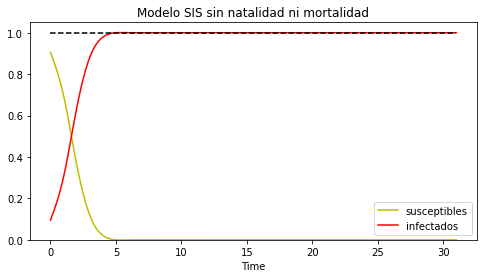

In [3]:
a=0.2; b=0.5
system = initialCondition(0.1, np.zeros((30,30)))
SISmodel = models("sis",a,b,system,Moore)

SISmodel.metricsPlot(30,"Modelo SIS sin natalidad ni mortalidad")

## El modelo SIR sin natalidad ni mortalidad

El modelo SIR describe el comportamiento entre tres estados por medio de dos relaciones, la que está presente cuando se pasa del estado S al estado I y la que describe el paso del estado I al estado R. Nosotros ya definimos una de estas relaciones, la del estado S al estado I con la regla de evolución $\phi^t(\alpha,\beta)$. Ahora definiremos la regla para el cambio del estado I al estado R:

Dado que la recuperación de una célula infectada no depende de ningún tipo de interacción con celdas recuperadas no se considerará el estado de los vecinos, en lugar de eso partiremos del concepto de $\alpha$, el cual nos indica que un individuo infectado tiene una probabilidad $\alpha$ de recuperarse, o lo que es equivalente, que $\alpha$ de la población infectada se recupera.

Aplicaremos la regla $\phi^{t+1}(\alpha,\beta)$ unicamente sobre todos los individuos susceptibles y posteriormente tomaremos la proporción $\alpha$ de celdas infectadas que se recuperaran por unidad de tiempo.

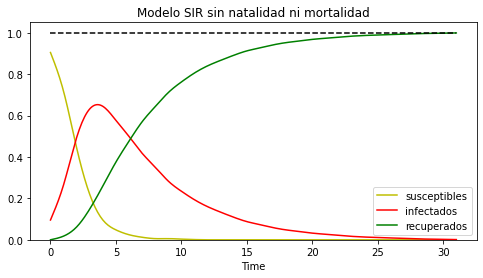

In [4]:
a=0.2; b=0.5
system = initialCondition(0.1, np.zeros((30,30)))
SISmodel = models("sir",a,b,system,Moore)

SISmodel.metricsPlot(30,"Modelo SIR sin natalidad ni mortalidad")

## Natalidad y mortalidad

Debido a que los modelos en ecuaciones diferenciales describen interacciones globales y no enfocadas a los individuos no es posible contemplar la idea de una probabilidad de muerte diferente para cada edad, en su lugar se considera la tasa de mortalidad $\mu$ como la esperanza de vida general en la población. Por otro lado, como estamos considerando modelos en los que el tamaño de la población es constante, en el caso de los modelos tradicionales la tasa de natalidad debe ser igual a la tasa de mortalidad. Esto representa una gran limitación para el modelo ya que esto no necesariamente es cierto.

A diferencia de los modelos clásicos, los autómatas celulares nos permiten solucionar este tipo de inconvenientes por sus mismas propiedades. Ya que estamos considerando un espacio finito y discreto, el tamaño de la población no podra variar y por otra parte, la natalidad y la mortalidad se pueden modelar como conceptos "independientes" ya que en lugar de considerar una esperanza de vida podemos plantearnos probabilidades de muerte diferentes para cada célula con base en su edad.

Para definir las edades de las células es necesario realizar un estudio demográfico previo de la población que se va a modelar. Una vez se definan las "probabilidades de muerte por grupo de edad", digamos $\mu_0,\mu_1\cdots,\mu_n$ para los grupos $[a_0,a_1),[a_1,a_2),\cdots,[a_{n-1},a_n]$, se debe establecer la relación entre cantidad de iteraciones y tiempo en un año.

Una vez se cumpla la cantidad de iteraciones necesarias para modelar un año, todas las células que posean algún tipo de interación "cumpliran un año", esto implica que las celdas envejeceran y de ese modo su probabilidad de morir aumentará o disminuirá dependiendo de los posibles casos que se definan.

La muerte de una célula se representará con una nueva etiqueta o estado para la célula, el estado de espacio en blanco D. Las celdas que cuenten con este estado no cumpliran años y su contacto con otras células no representara variación alguna en la evolución de sus estados.

Como se posee un limite en la cantidad de individuos en el espacio por su misma naturaleza, los "nacimientos" se podran efectuar unicamente si el medio lo permite, esto se puede ver representado con los espacios en blanco que dejan las células que mueren. Para que una célula ocupe uno de estos espacios se debe considerar un nuevo parámetro que entenderemos como la cantidad promedio de hijos que puede tener una madre en la población que estamos modelando.

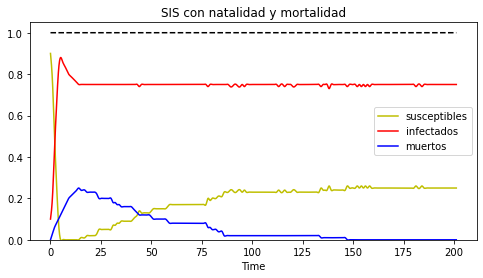

In [5]:
system1 = initialCondition(0.1,np.zeros((10,10)))
ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
ages_sys1 = agesMatrix(ranges,system1)

mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
br = 2

sm_1 = models("sis_birthAndMortavility",0.2,0.5,system1,Moore)
sm_1.birthRate = br; sm_1.probabilityOfDyingByAgeGroup = mr
sm_1.systemAges = ages_sys1; sm_1.annualUnit = 365
sm_1.metricsPlot(200,"SIS con natalidad y mortalidad")

## Muerte por enfermedad (Pendiente)

1. Simulating Complex Systems by Cellular Automata
2. MODELING INFECTIOUS DISEASES USING GLOBAL STOCHASTIC CELLULAR AUTOMATA
3. Epidemiological modeling with a population density map-based cellular automata simulation system
4. Descripción y Aplicaciones de los Autómatas Celulares
5. Autómatas Celulares y su Aplicación en Computación